<h3>Variable Infomation</h3>
<p>- BAD: 1 = người nộp đơn đã vỡ nợ hoặc nợ quá hạn nghiêm trọng; 0 = người nộp đơn đã thanh toán khoản vay 
<p>- LOAN: Số tiền yêu cầu vay
<p>- MORTDUE: Số tiền nợ còn lại trên khoản thế chấp hiện tại
<p>- VALUE: Giá trị tài sản hiện tại.
<p>- REASON: lý do vay DebtCon = debt consolidation (ghép nợ); HomeImp = home improvement (sửa sang nhà cửa).
<p>- JOB: loại công việc, bao gồm các nhóm “Office”, “Sales”, “Mananger”, “Professional Executive”, “Self business” và các công việc khác.
<p>- YOJ: Số năm làm việc tại công việc hiện tại
<p>- DEROG: Số lượng báo cáo vỡ nợ.
<p>- DELINQ: Số hạn mức tín dụng quá hạn
<p>- CLAGE:Tuổi của hạn mức tín dụng lâu nhất tính theo tháng
<p>- NINQ: Số lượng yêu cầu tín dụng gần đây
<p>- CLNO: Số lượng hạn mức tín dụng
<p>- DEBTINC: Tỷ lệ nợ/thu nhập

In [2]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from scipy.stats import probplot
from statistics import mean, stdev
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve, auc, confusion_matrix, f1_score, classification_report, mean_absolute_error, log_loss
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [3]:
# Đọc dữ liệu từ file hmeq.csv
data = pd.read_csv('./dataset/hmeq.csv')

In [3]:
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
data.shape

(5960, 13)

In [5]:
# Các thuộc tính của dữ liệu
data.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


<p>Bộ dữ liệu chứa tổng cộng 5960 hàng và 13 cột.
<p>Cột "BAD" là biến mục tiêu, cho biết khách hàng có vỡ nợ (1) hay không vỡ nợ (0) khi thanh toán khoản vay của họ. 

<p>Bộ dữ liệu bao gồm 9 thuộc tính dạng số: "LOAN," "MORTDUE," "VALUE," "YOJ," "DEROG," "DELINQ," "CLAGE," "NINQ," "CLNO" và "DEBTINC".
<p>Bộ dữ liệu bao gồm 2 thuộc tính dạng phân loại: "REASON" và "JOB".

In [7]:
# Xem có bao nhiêu giá trị null trong thuộc tính/biến
missing_data = data.isnull().sum().rename_axis("Variable").reset_index(name="Missing Value")
missing_data

,Variable,Missing Value
0,BAD,0
1,LOAN,0
2,MORTDUE,518
3,VALUE,112
4,REASON,252
5,JOB,279
6,YOJ,515
7,DEROG,708
8,DELINQ,580
9,CLAGE,308


<p>Một số cột bị thiếu giá trị: "MORTDUE", "VALUE", "REASON", "JOB", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO" và "DEBTINC".

In [9]:
# Tỉ lệ giá trị bị nulll theo % của thuộc tính
missing_value = ((data.isnull().sum() / len(data.index)) * 100).sort_values()
missing_data_ratio = missing_value.rename_axis("Variable").reset_index(name = "Missing Value Ratio")
missing_data_ratio

,Variable,Missing Value Ratio
0,BAD,0.000000
1,LOAN,0.000000
2,VALUE,1.879195
3,CLNO,3.724832
4,REASON,4.228188
5,JOB,4.681208
6,CLAGE,5.167785
7,NINQ,8.557047
8,YOJ,8.640940
9,MORTDUE,8.691275


<p>Quan sát: 
<p>+ Ngoại trừ BAD và LOAN thì tất cả các trường khác đều có những giá trị chưa được khai báo.
<p>+ 'DEBTINC' có tỷ lệ giá trị bị thiếu cao nhất, khoảng 21%. Điều này cho thấy rằng một phần đáng kể dữ liệu bị thiếu cho tính năng này.
<p>+ Các cột 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ' và 'NINQ' có tỷ lệ phần trăm giá trị bị thiếu tương đối cao,dao động từ khoảng 8% đến 12%.
<p>+ Các cột 'REASON', 'JOB', 'CLAGE' và 'CLNO' có tỷ lệ phần trăm giá trị bị thiếu vừa phải, dao động từ khoảng 3% đến 5%.

In [10]:
# Kiểm tra giá trị trùng lặp
data.duplicated().sum()

0

<p> Không có hàng trùng lặp trong dữ liệu

In [11]:
# show ra chi tiết các thống kê với biến/ thuộc tính dạng numerical (tức biến/ thuộc tính dạng số)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000


<p>BAD: Cột "BAD" thể hiện việc khách hàng vỡ nợ (1) hay không vỡ nợ (0) khi thanh toán khoản vay của họ. Tỷ lệ vỡ nợ trung bình là khoảng 19,95%.

LOAN: Cột "LOAN" thể hiện số tiền vay mà khách hàng yêu cầu. Số tiền cho vay trung bình là khoảng 18.608 với nhiều giá trị khác nhau. Số tiền vay cao nhất là khoảng 89.900.

MORTDUE: Cột "MORTDUE" thể hiện số tiền thế chấp hiện tại đến hạn đối với tài sản. Khoản thế chấp trung bình đến hạn là khoảng 73.761.

VALUE: Cột "VALUE" biểu thị giá trị của thuộc tính. Giá trị thuộc tính trung bình là khoảng 101.776, với nhiều giá trị khác nhau. Giá trị tài sản cao nhất là 855.909.

REASON: Cột "REASON" thể hiện lý do cho khoản vay, với hai giá trị duy nhất: "DebtCon" (Hợp nhất Nợ) và "HomeImp" ​​(Cải thiện Nhà). Lý do phổ biến nhất cho khoản vay là hợp nhất nợ (DebtCon).

JOB: Cột "JOB" thể hiện loại công việc của khách hàng. Có sáu loại công việc riêng biệt, trong đó "Other" là loại công việc phổ biến nhất.

YOJ: Cột "YOJ" thể hiện số năm làm việc của khách hàng. Số năm làm việc trung bình là khoảng 8,92 năm.

DEROG: Cột "DEROG" thể hiện số lượng báo cáo vỡ nợ của khách hàng. Số lượng báo cáo vỡ nợ trung bình là khoảng 0,25.

DELINQ: Cột "DELINQ" biểu thị số hạn mức tín dụng quá hạn trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng quá hạn trung bình là khoảng 0,45.

CLAGE: Cột "CLAGE" thể hiện tuổi của dòng tín dụng lâu đời nhất tính theo tháng. Tuổi trung bình của dòng tín dụng lâu đời nhất là khoảng 179,77 tháng.

NINQ: Cột "NINQ" biểu thị số hạn mức tín dụng gần đây trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng trung bình gần đây là khoảng 1,19.

CLNO: Cột "CLNO" biểu thị số hạn mức tín dụng trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng trung bình là khoảng 21,30.

DEBTINC: Cột "DEBTINC" thể hiện tỷ lệ nợ trên thu nhập của khách hàng. Tỷ lệ nợ trên thu nhập trung bình là khoảng 33,78.

Split the Data into Train and Test set

In [4]:
X = data.drop(['BAD'], axis=1)
y = data['BAD']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print("Train data: ", X_train.shape)
print("Test Data: ", X_test.shape)

Train data:  (4768, 12)
Test Data:  (1192, 12)


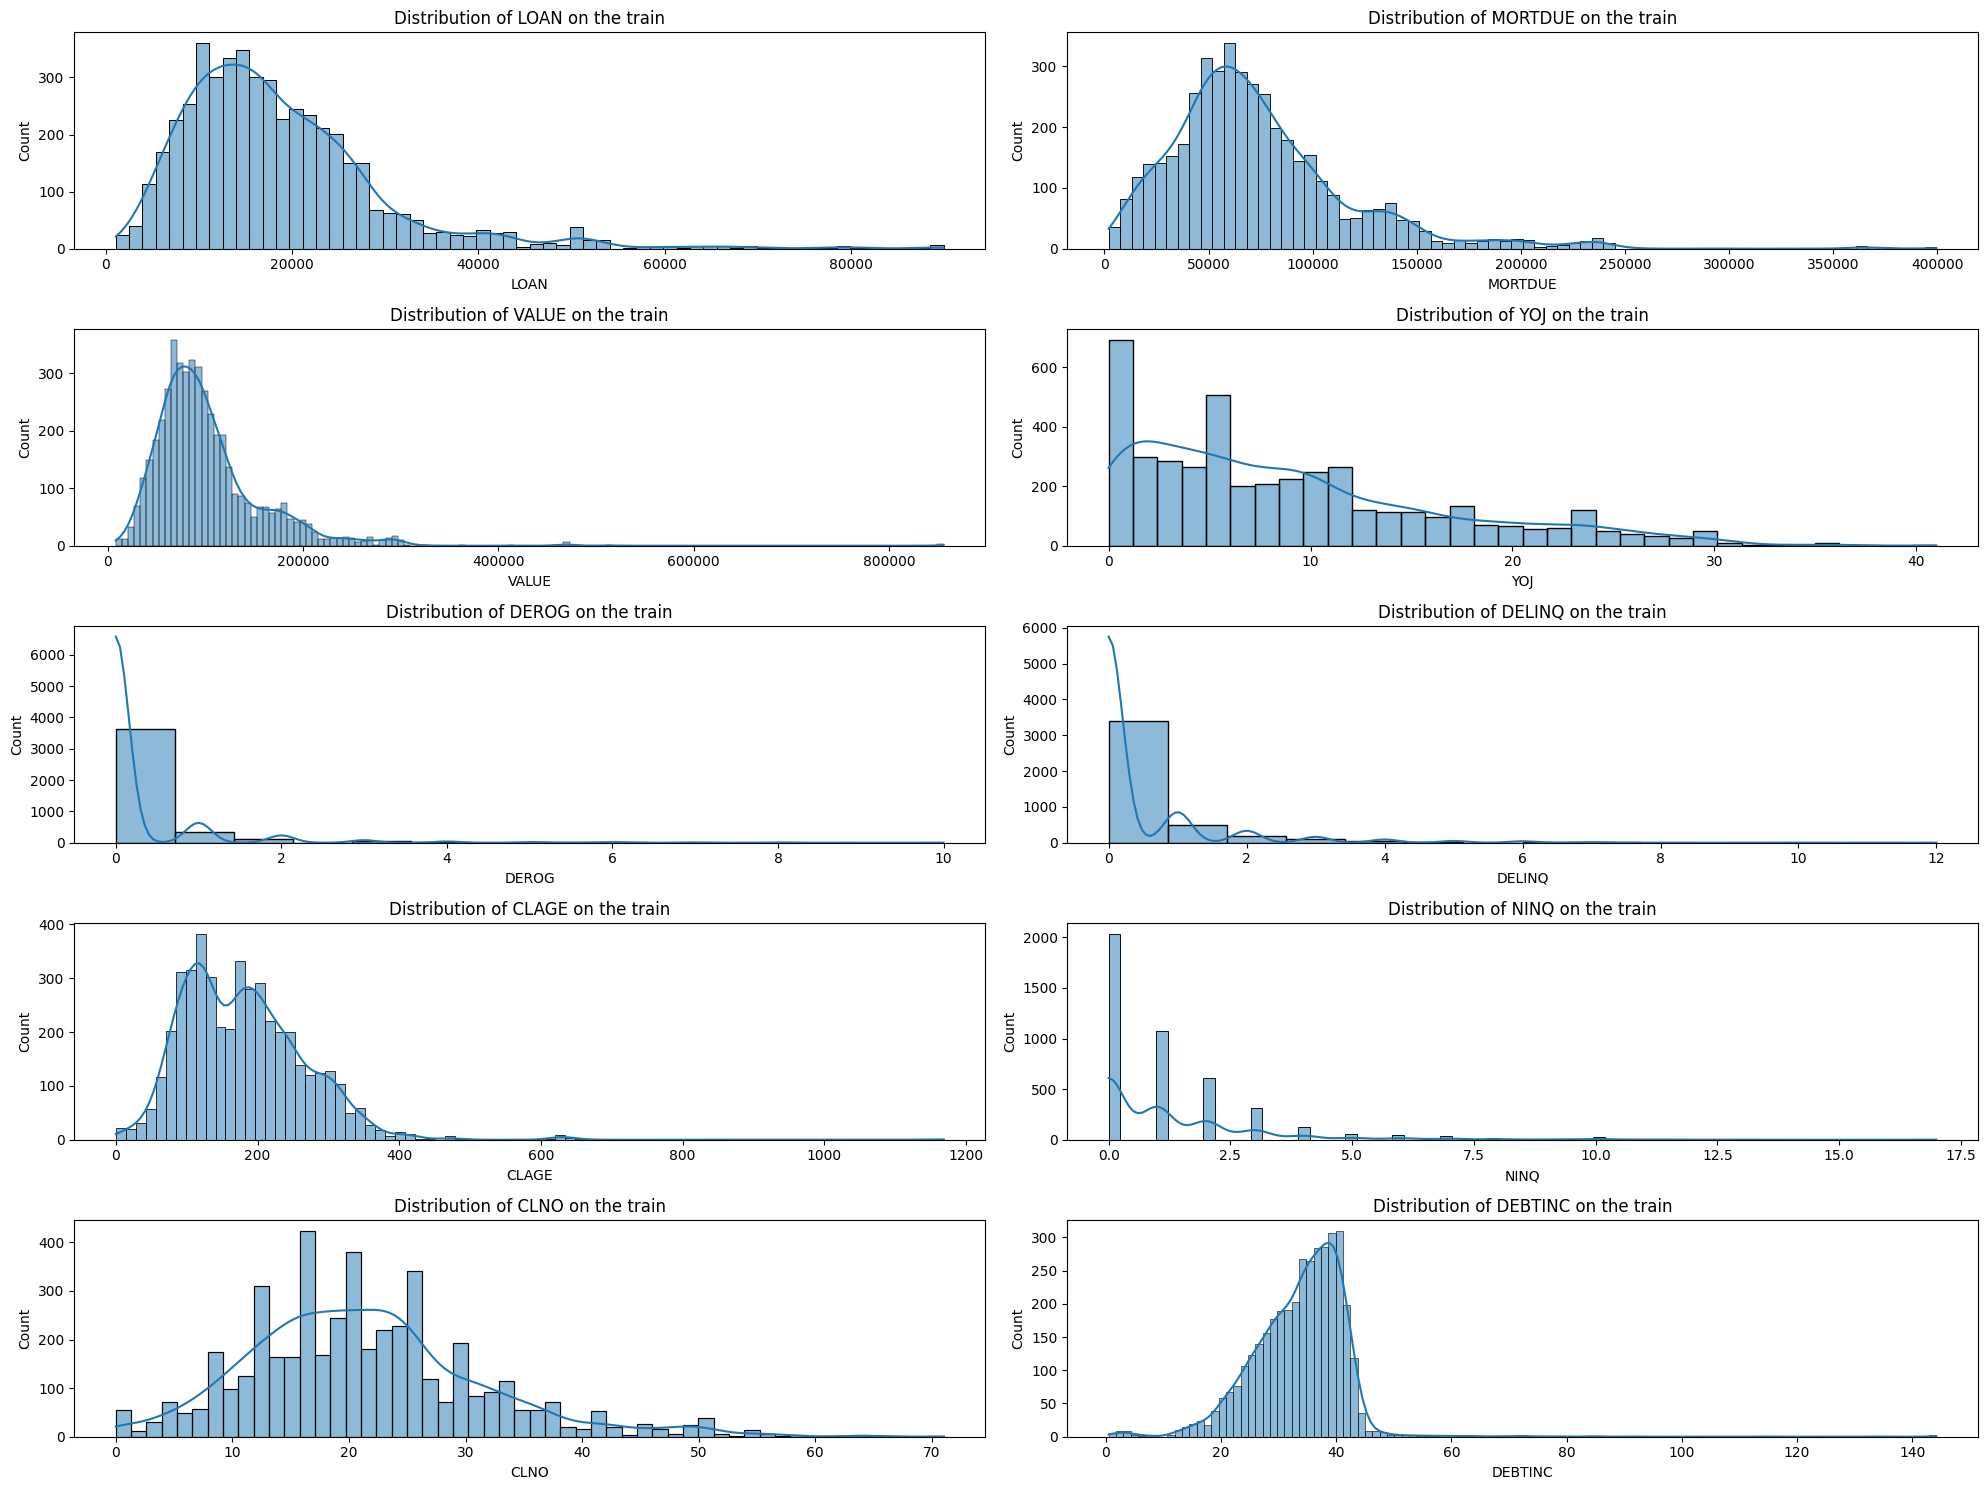

In [15]:
num_col = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO','DEBTINC']
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sns.histplot(X_train[col], kde = True)
    plt.title(f'Distribution of {col} on the train')

plt.tight_layout()
plt.show()

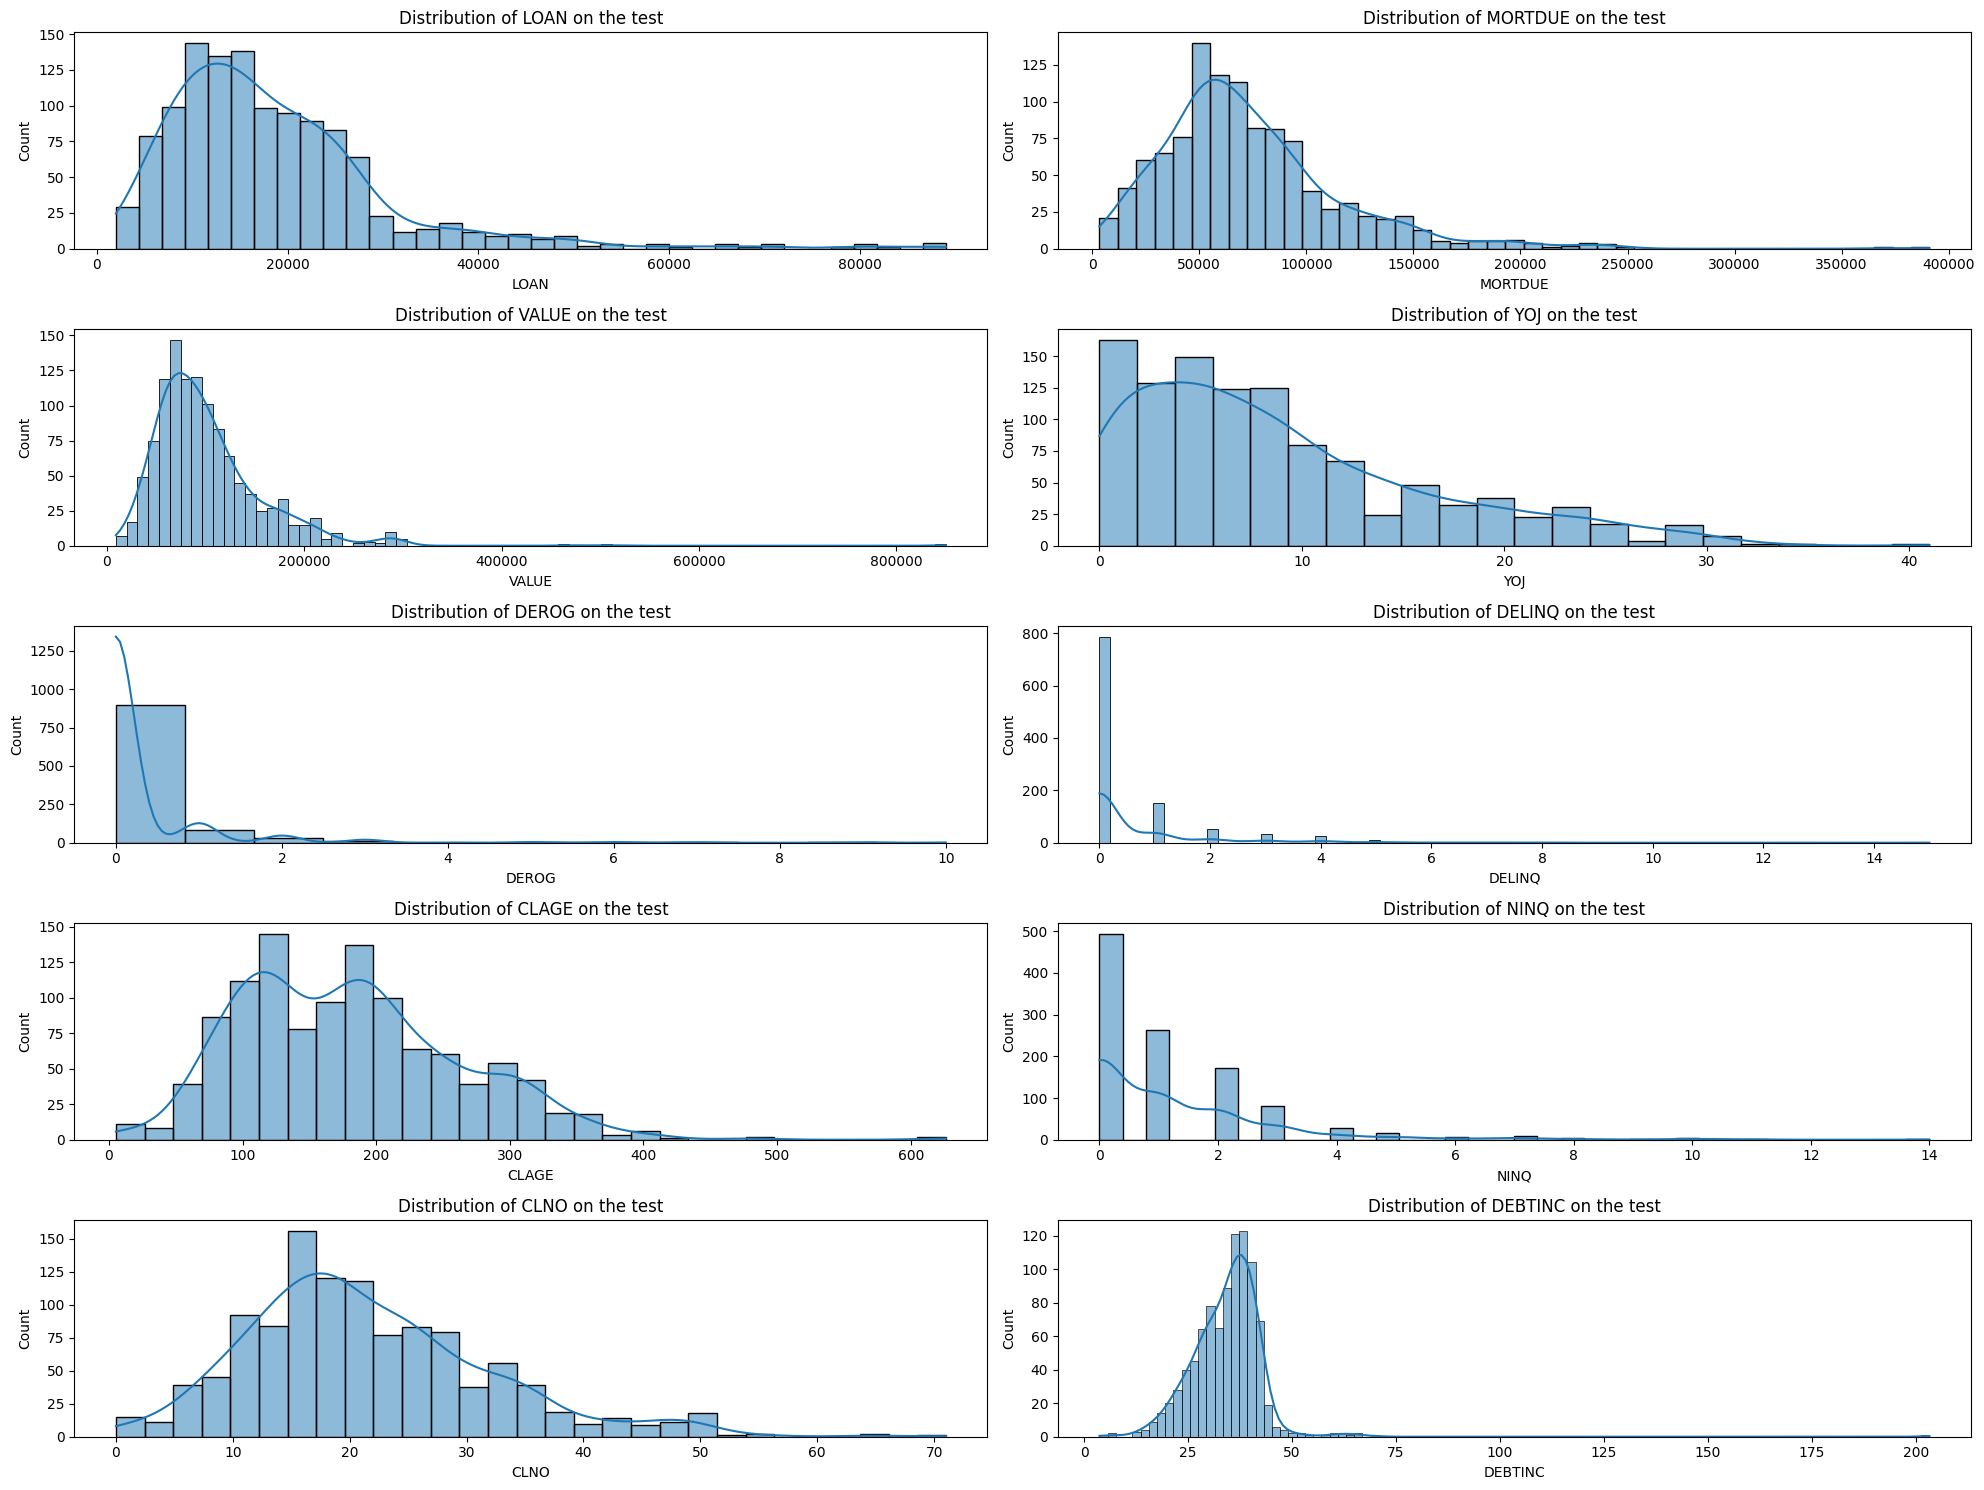

In [16]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sns.histplot(X_test[col], kde = True)
    plt.title(f'Distribution of {col} on the test')

plt.tight_layout()
plt.show()

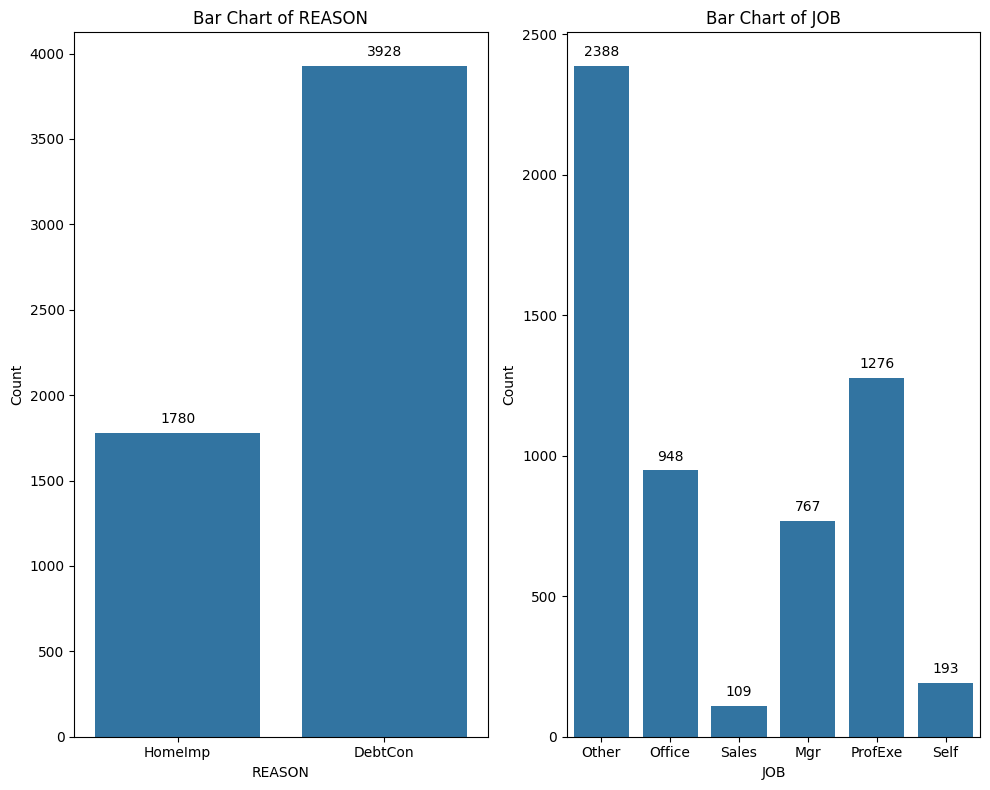

In [17]:
# Barchart cho biến phân loại
cate_columns = ['REASON', 'JOB']
plt.figure(figsize=(10, 8))
for i, col in enumerate(cate_columns):
    plt.subplot(1, len(cate_columns), i+1)
    ax = sns.countplot(data=data, x=col)
    plt.title(f'Bar Chart of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

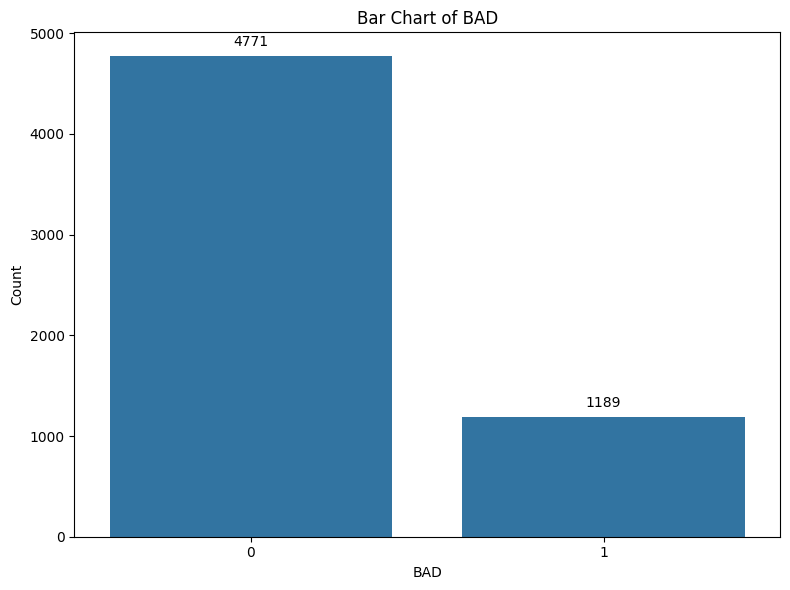

In [18]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=data, x='BAD')
plt.title('Bar Chart of BAD')
plt.xlabel('BAD')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()

<p>Nhận xét: Qua sự phân bố của các trường có thể thấy rằng: </p>
<p>+ Hầu như các trường dữ liệu dạng numeric đều không theo phân phối chuẩn</p>
<p>+ Các trường dữ liệu dạng category đều có sự chênh lệch đang kể về sự phân phối của các giá trị</p>
<p>+ Các trường dữ liệu dạng numeric đều có thiên hướng lệch phải trên cả tập train và tập test


<h3>Correlation between variables

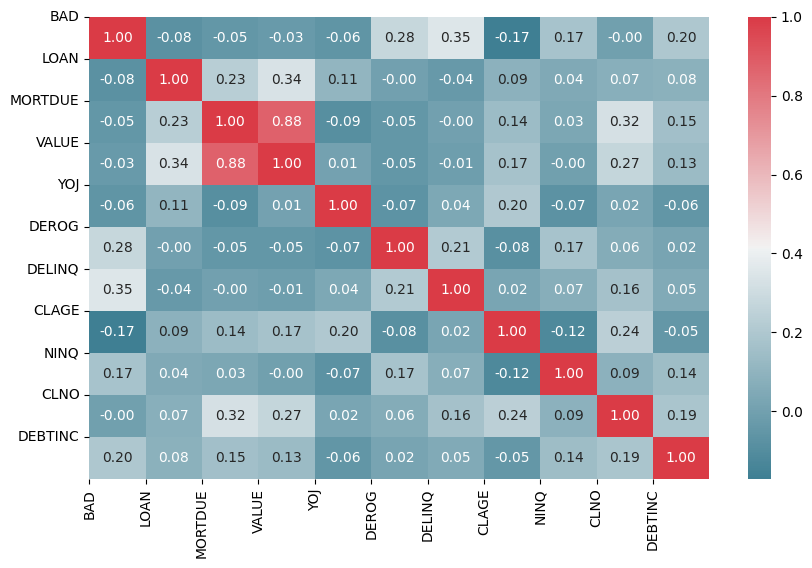

In [19]:
numeric_col = data.select_dtypes(include='number')
corr = data[numeric_col.columns].corr()
fig, ax = plt.subplots(figsize=(10,6))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()


In [20]:
def variable_with_target(data):
    # Create subplots for bar plots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    fig.suptitle("Relationships between 'BAD' and Different Features", fontsize=16)

    # Bar plot for 'REASON'
    REASON=pd.crosstab(data['REASON'],data['BAD'])
    REASON.div(REASON.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='REASON vs BAD', ax = axes[0,0])

    # Bar plot for 'JOB'
    JOB=pd.crosstab(data['JOB'],data['BAD'])
    JOB.div(JOB.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='JOB vs BAD', ax = axes[0,1])

    # Bar plot for 'DEROG'
    DEROG=pd.crosstab(data['DEROG'],data['BAD'])
    DEROG.div(DEROG.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='DEROG vs BAD', ax = axes[1,0])

    # Bar plot for 'DELINQ'
    DELINQ=pd.crosstab(data['DELINQ'],data['BAD'])
    DELINQ.div(DELINQ.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='DELINQ vs BAD', ax = axes[1,1])

    # Bar plot for 'NINQ'
    NINQ=pd.crosstab(data['NINQ'],data['BAD'])
    NINQ.div(NINQ.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='NINQ vs BAD', ax = axes[2,0])

    # Bar plot for 'DEBTINC'
    bins=[0,40,100,204] 
    group=['Low','Average','High'] 
    dfWithBin = pd.DataFrame()
    dfWithBin['DEBTINC_bin']=pd.cut(data['DEBTINC'],bins,labels=group)
    LOAN_bin=pd.crosstab(dfWithBin['DEBTINC_bin'],data['BAD'])
    LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,title='DEBTINC vs BAD', ax = axes[2,1])
    plt.xlabel('DEBTINC')

    # Adjust layout and display plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

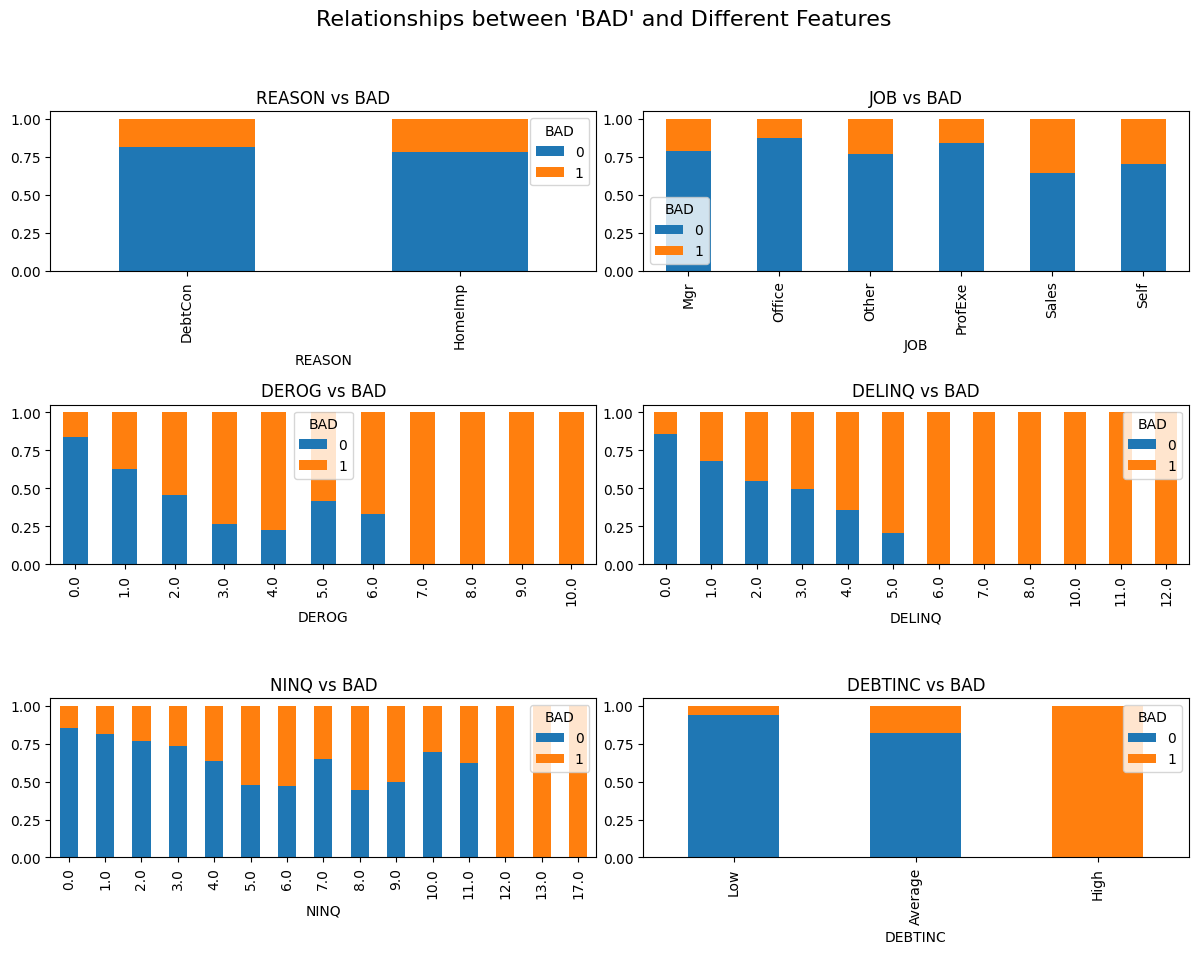

In [21]:
data_corr = X_train.copy()
data_corr["BAD"] = y_train
variable_with_target(data_corr)

<h5>Nhận xét: Đồ thị bên trên biểu diễn sự phụ thuộc của biến dự đoán vào các biến có tính tương quan cao với biến dự đoán: REASON, JOB, DEROG, DELINQ, NINQ, DEBTINC.</h5>
<p>+ Tỉ lệ vỡ nợ do HomeImp (sửa sang nhà cửa) cao hơn tỉ lệ vỡ nợ do DebtCon (vay ghép nợ)
<p>+ Tỉ lệ vỡ nợ do làm công việc Sales cao nhất và tỉ lệ vỡ nợ khi làm các công việc Office là thấp nhất
<p>+ Với số lượng báo cáo vỡ nợ càng nhiều thì khả năng vỡ nợ càng lớn. Và khi số lượng báo cáo vỡ nợ đạt ngưỡng 7 báo cáo trở nên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Với số hạn mức tín dụng quá hạn càng nhiều thì khả năng vỡ nợ càng lớn. Và khi số hạn mức tín dụng quá hạn đạt ngưỡng 6 trở lên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Với số lượng yêu cầu tín dụng càng nhiều thì dường như khả năng vỡ nợ càng lớn. Và khi số lượng yêu cầu tín dụng đạt ngưỡng 12 trở lên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Tỉ lệ (nợ/thu nhập) càng lớn, tức là số tiền nợ hàng tháng phải trả quá cao so với mức lương thu nhập thì khả năng xảy ra vỡ nợ càng cao. Và nếu tỉ lệ này vượt quá 100% thì khả năng vỡ nợ gần như là 100%

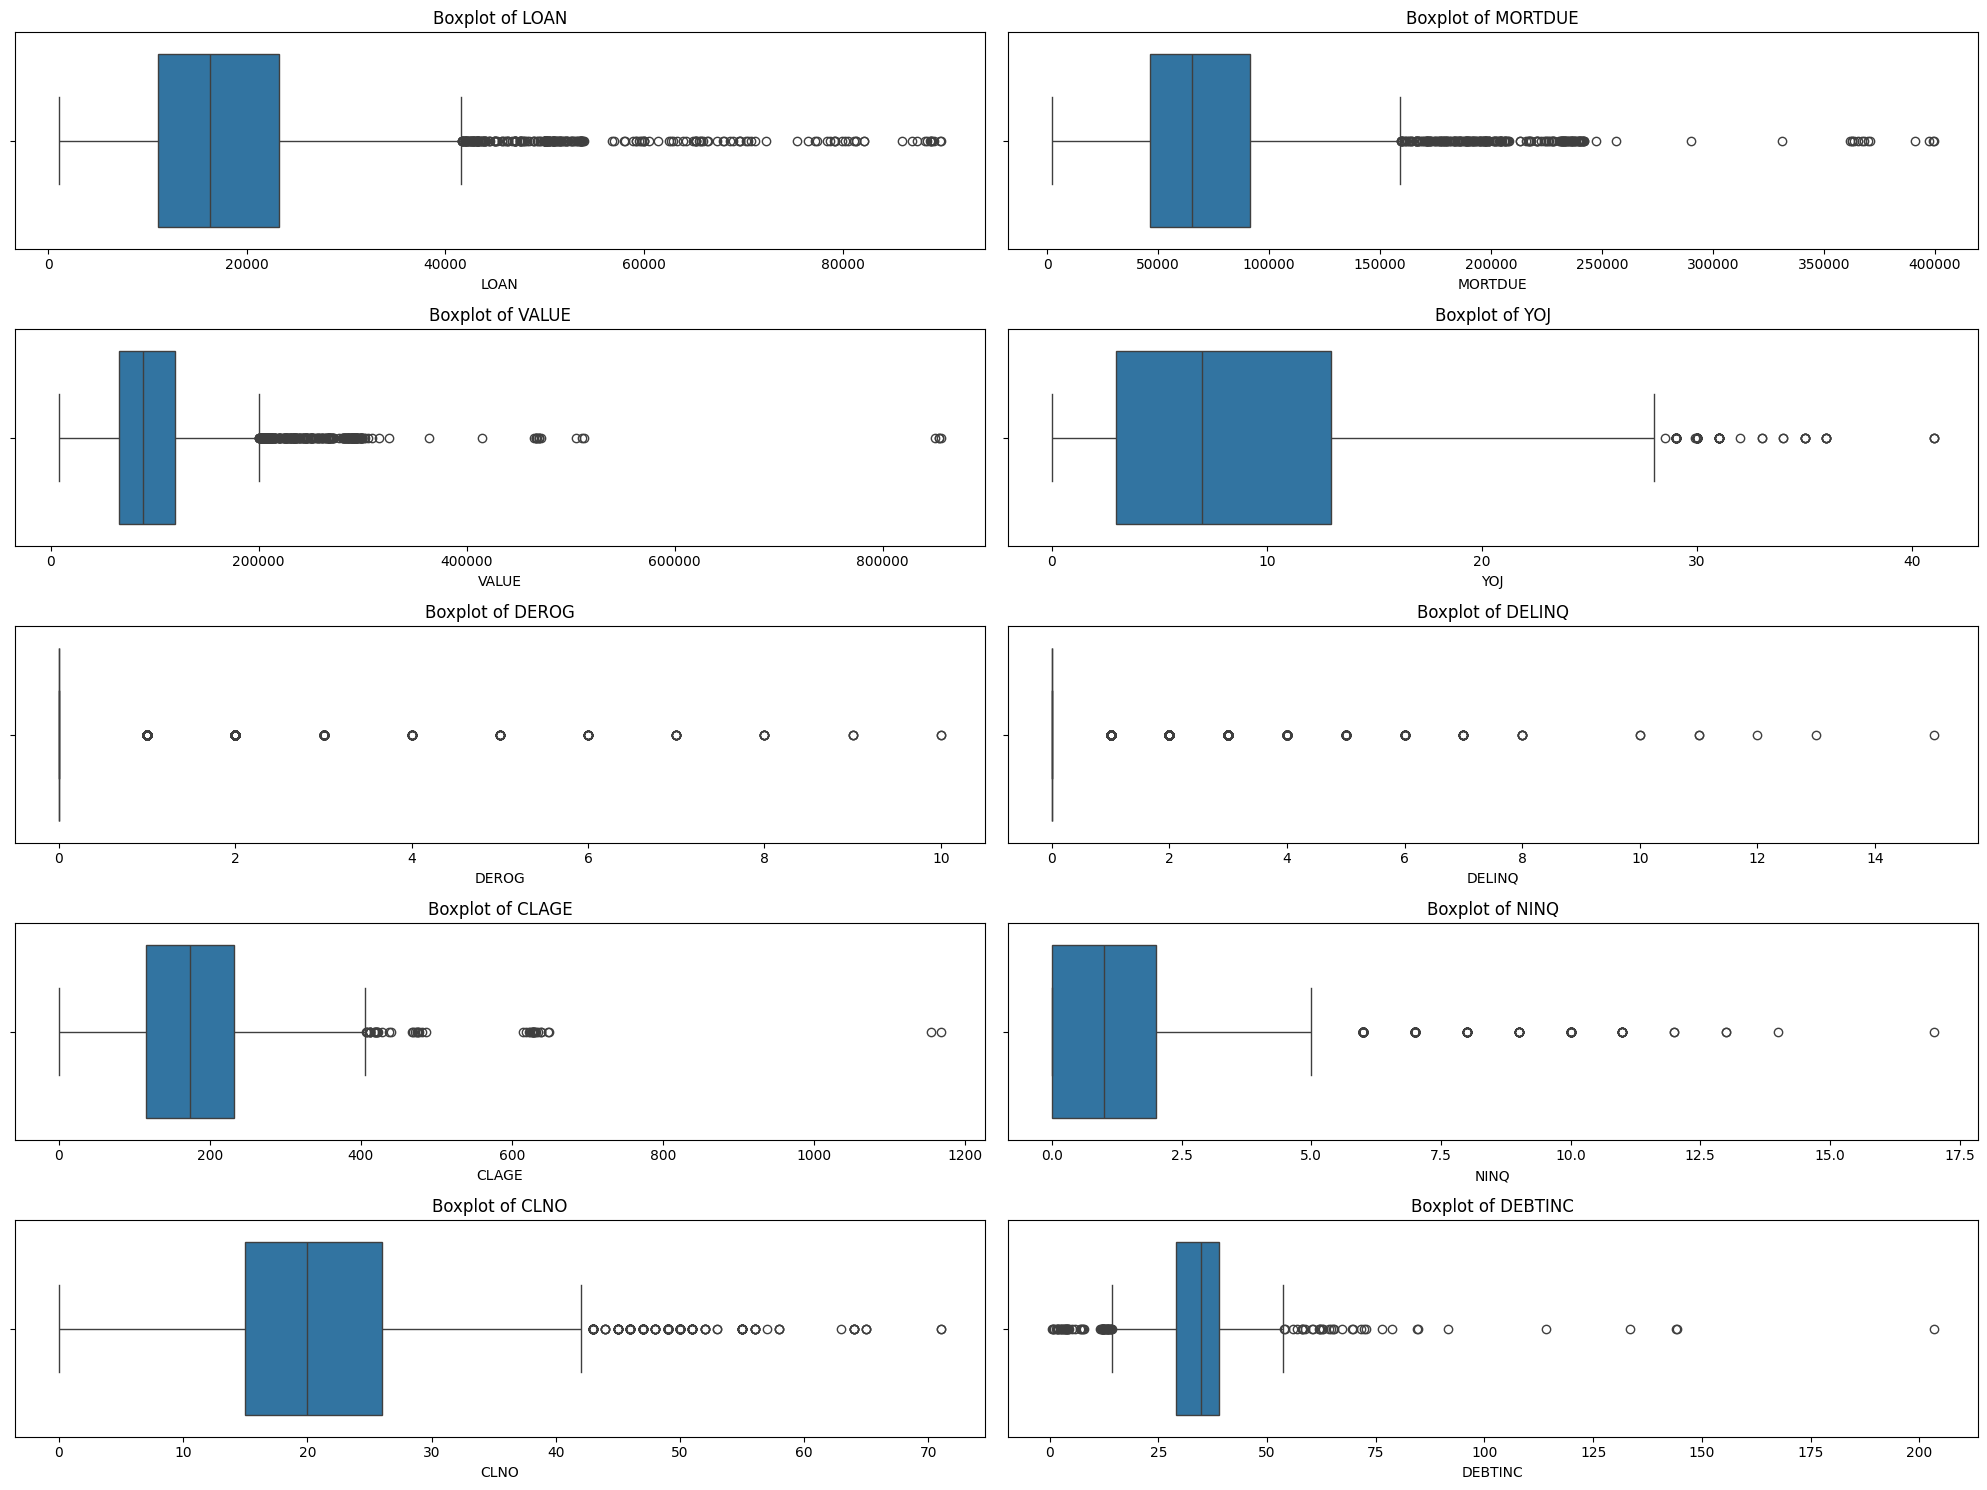

In [23]:
# Box plot: IQR và các điểm ngoại lai
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

<h3>Data Preprocessing</h3>

In [12]:
# Hàm thay thế các giá trị Nan trong các trường dữ liệu
def inplace_nan(x, y):
    for column in x.columns[1:]:
        if x[column].dtype == 'object':
            x[column] = x[column].fillna("Missing")
                        
        else:
            # Vì trong các trường dữ liệu số đều có giá trị outlier nên sẽ thay thế bởi giá trị median
            # Với record có target là 0 sẽ fillna với giá trị median của các record có target = 0
            # Với record có target là 1 sẽ fillna với giá trị median của các record có target = 1
            x.loc[(x[column].isna()) & (y == 0), column] = round(x[y == 0][column].median(), 0)
            x.loc[(x[column].isna()) & (y == 1), column] = round(x[y == 1][column].median(), 0)
    return x, y

In [28]:
# Remove outlier
def remove_outlier_IQR(x, y, columns):
    df = pd.concat([x, y], axis=1)
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    df_final = df[~outlier_mask]

    x = df_final.iloc[:, :len(x.columns)]
    y = df_final.iloc[:, len(x.columns):]

    return x, y

<h3>Standardized data</h3>

In [34]:
def preprocess_standard(X, y, index, save): 

  scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
  scaled_features = scaler.fit_transform(X)

  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  if save:
    pickle.dump(scaler, open(f'./standards/StandardScaler{index}.pkl', 'wb'))
  return scaled_features_df,y

def preprocess_min_max(X, y, index, save):

  scaler = MinMaxScaler()
  scaled_features = scaler.fit_transform(X)

  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  if save:
    pickle.dump(scaler, open(f'./standards/MinMaxScaler{index}.pkl', 'wb'))
  return scaled_features_df,y

In [35]:
X_train_1, X_test_1, y_train_1, y_test_1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

<p>+ Với giá trị phân loại: thay thế bằng giá trị Missing 
<p>+ Với giá trị số: thay thế bằng giá trị median của các record có target tương ứng
<p>Sau đó OneHotEncoder những trường chứa giá trị phân loại
<p>Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [38]:
# Thay thế các giá trị Nan
X_train_1, y_train_1 = inplace_nan(X_train_1, y_train_1)
X_test_1, y_test_1 = inplace_nan(X_test_1, y_test_1)

# OnehotEncoder
X_train_1 = pd.get_dummies(X_train_1, columns=['REASON', 'JOB'])
X_test_1 = pd.get_dummies(X_test_1, columns=['REASON', 'JOB'])


# Chuẩn hóa dữ liệu theo pp StandardScaler
X_train_1, y_train_1 = preprocess_standard(X_train_1, y_train_1, 1, True)
X_test_1, y_test_1 = preprocess_standard(X_test_1, y_test_1, 1, True)

<h2>Model

In [53]:
def plot_roc(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC plot for loan defaulter prediction")
    plt.legend(loc="lower right")
    plt.show()


In [54]:
def plot_confusion_matrix(y_true, y_pred, labels=None, figsize=(8, 6), cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels if labels is not None else [], yticklabels=labels if labels is not None else [])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [55]:
def model_analysis(model, X_test, y_test, y_pred):
    plot_roc(model, X_test, y_test)
    plot_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

In [56]:
def tuning_hyperparameter_grid(model, param_grid, X_train, y_train):
    clf_grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid = clf_grid.fit(X_train, y_train)
    print('Best train: %f using %s' % (grid.best_score_, grid.best_params_))
    return grid.best_estimator_

In [57]:
def build_and_train_model(models, param_grids, X_train, y_train, X_test, y_test, index):
    for i, (model, param_grid) in enumerate(zip(models, param_grids)):
        print(f'Model {i+1}: {type(model).__name__}')
        
        best_model = tuning_hyperparameter_grid(model, param_grid, X_train, y_train)
        train_accuracy = best_model.score(X_train, y_train)
        test_accuracy = best_model.score(X_test, y_test)
        
        y_pred_train = best_model.predict(X_train)
        recall_train = recall_score(y_train, y_pred_train)
        
        y_pred_test = best_model.predict(X_test)
        recall_test = recall_score(y_test, y_pred_test)
        
        print(f'Accuracy on Training Set: {train_accuracy:.4f}')
        print(f'Accuracy on Test Set: {test_accuracy:.4f}')
        print(f'Recall on Training Set: {recall_train:.4f}')
        print(f'Recall on Test Set: {recall_test:.4f}')
        
        print("Training set")
        model_analysis(best_model, X_train, y_train, y_pred_train)
        print("Testing Set:")
        model_analysis(best_model, X_test, y_test, y_pred_test)
        
        # Ensure the directory exists
        model_name = type(best_model).__name__
        model_path = f"models/{model_name}{index}.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(best_model, f)
        
        print("\n\n\n\n")

In [58]:
log_param_grid = {
    'solver': ['saga', 'liblinear'],
    'penalty': ['l2', 'l1'],
    'C': [0.001, 0.1, 10, 100, 1000, 10000],
    'max_iter': [50, 100, 500, 1000]
}


dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 6, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}


rf_param_grid = { 
    'n_estimators':[50, 100, 200, 300, 500],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': [.7, 1],
} 


knn_param_grid = { 
    'n_neighbors' : [1,2,3,4,5,6,7,8],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']}

svm_param_grid = {
    'kernel':['rbf'],
    'C':[0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001]}

xgb_param_grid = {
    'max_depth': [3, 5, 7, 9],
    'gamma': [0.1, 0.5, 1.0, 1.5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}


In [59]:
log_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
svm_model = SVC(probability=True)
xgb_model = XGBClassifier()
    
models = [log_model, dt_model, rf_model, knn_model, svm_model, xgb_model]
param_grids = [log_param_grid, dt_param_grid, rf_param_grid, knn_param_grid, svm_param_grid, xgb_param_grid]


Model 1: LogisticRegression
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best train: 0.844703 using {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Accuracy on Training Set: 0.8547
Accuracy on Test Set: 0.8331
Recall on Training Set: 0.3690
Recall on Test Set: 0.3283
Training set


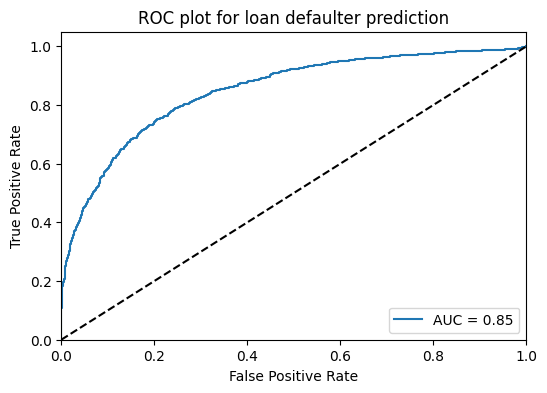

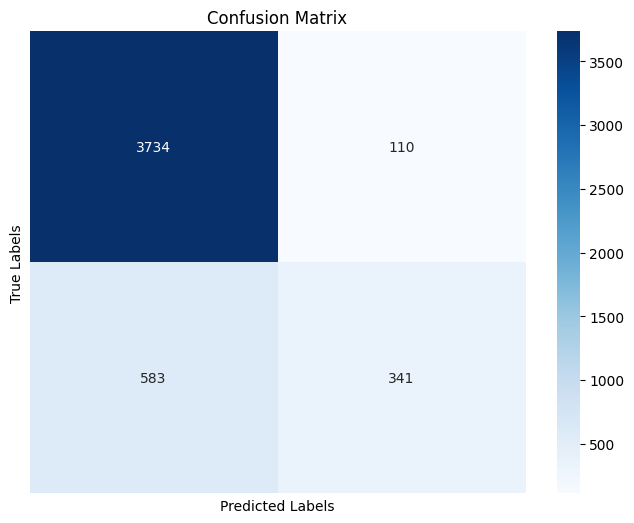

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      3844
           1       0.76      0.37      0.50       924

    accuracy                           0.85      4768
   macro avg       0.81      0.67      0.71      4768
weighted avg       0.84      0.85      0.83      4768

Testing Set:


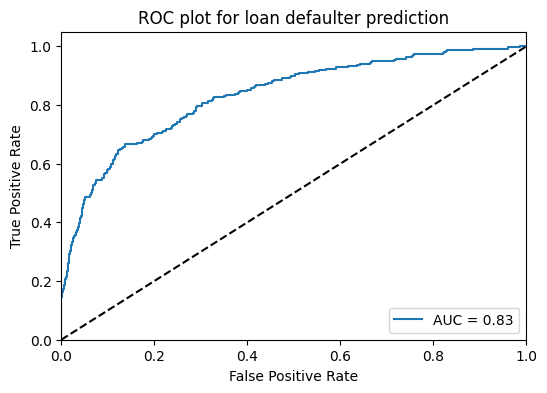

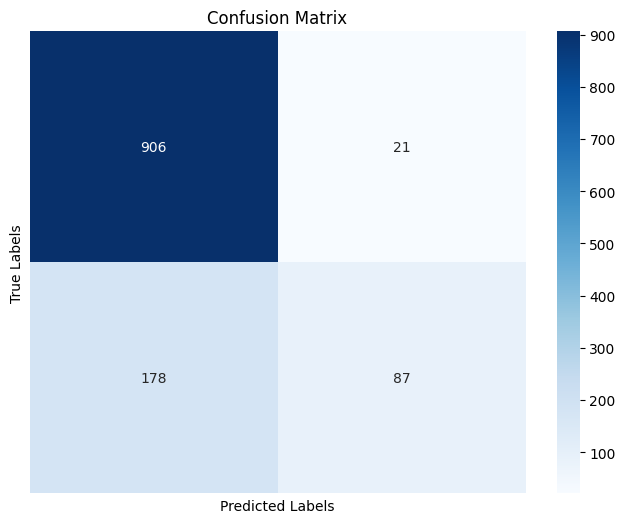

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       927
           1       0.81      0.33      0.47       265

    accuracy                           0.83      1192
   macro avg       0.82      0.65      0.68      1192
weighted avg       0.83      0.83      0.80      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best train: 0.927858 using {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy on Training Set: 0.9652
Accuracy on Test Set: 0.8305
Recall on Training Set: 0.8442
Recall on Test Set: 0.2604
Training set


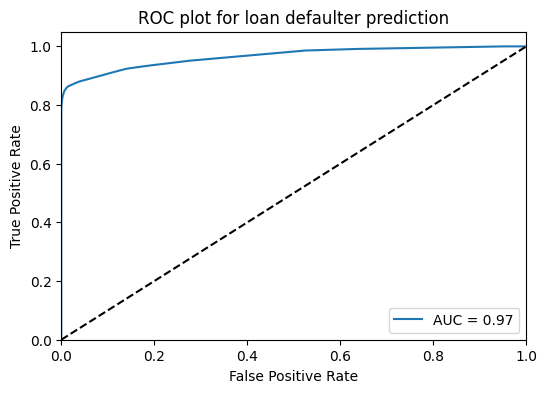

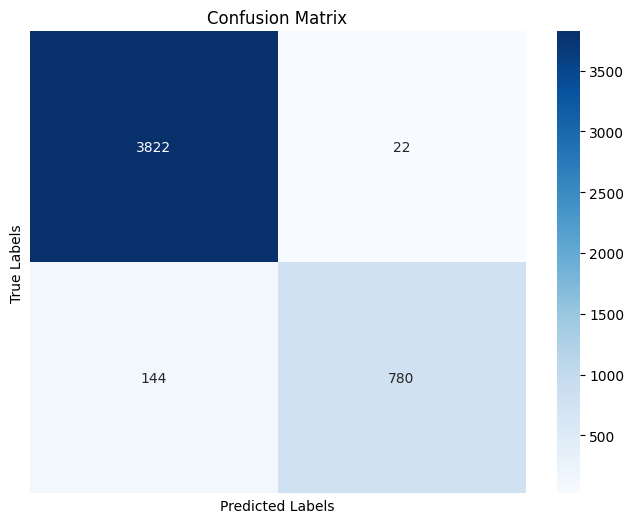

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3844
           1       0.97      0.84      0.90       924

    accuracy                           0.97      4768
   macro avg       0.97      0.92      0.94      4768
weighted avg       0.97      0.97      0.96      4768

Testing Set:


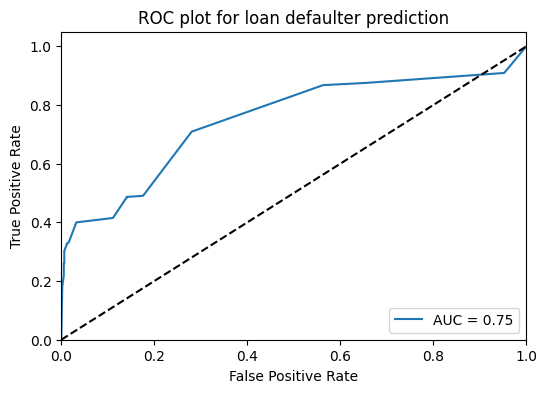

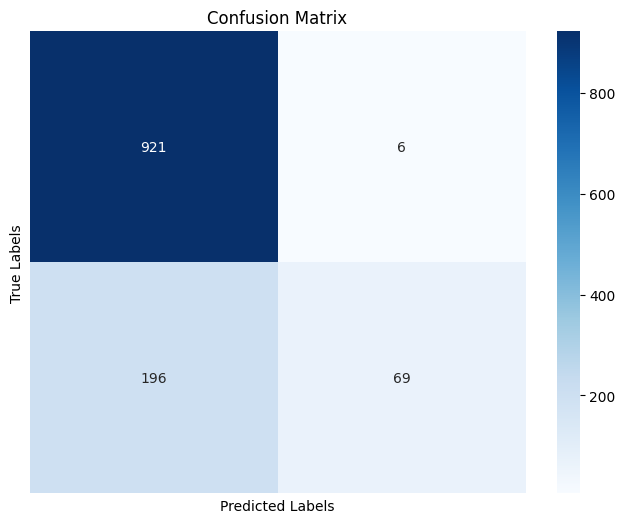

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       927
           1       0.92      0.26      0.41       265

    accuracy                           0.83      1192
   macro avg       0.87      0.63      0.65      1192
weighted avg       0.85      0.83      0.79      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best train: 0.994008 using {'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8565
Recall on Training Set: 1.0000
Recall on Test Set: 0.3547
Training set


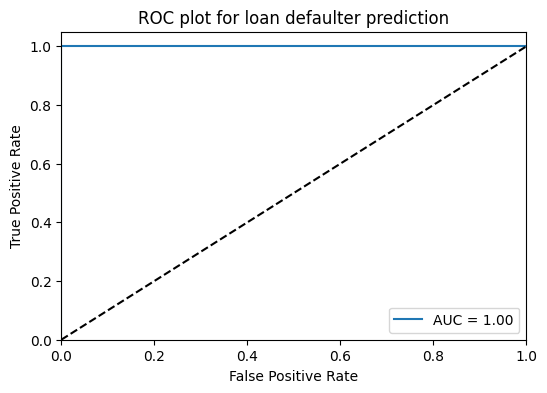

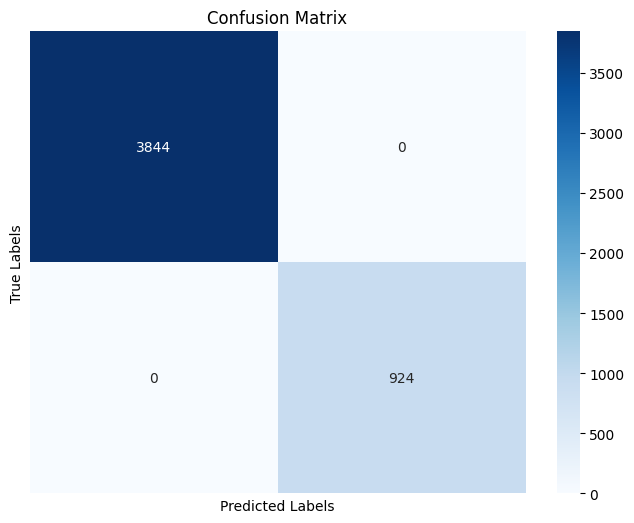

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3844
           1       1.00      1.00      1.00       924

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768

Testing Set:


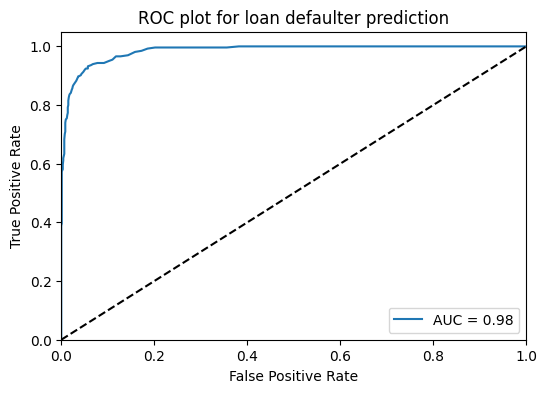

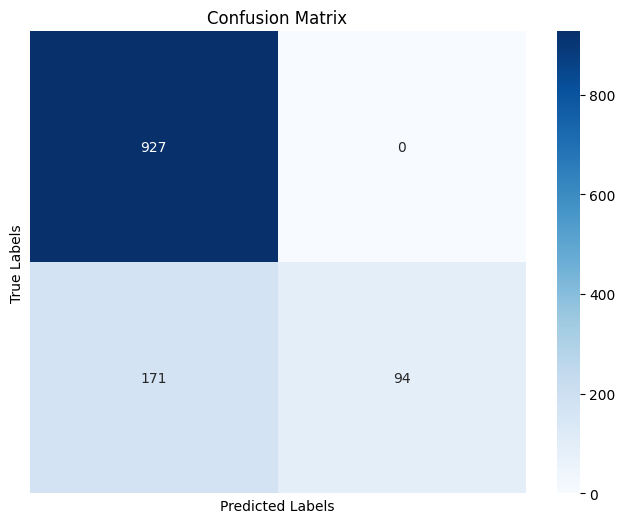

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       927
           1       1.00      0.35      0.52       265

    accuracy                           0.86      1192
   macro avg       0.92      0.68      0.72      1192
weighted avg       0.88      0.86      0.83      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.944771 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8708
Recall on Training Set: 1.0000
Recall on Test Set: 0.4264
Training set


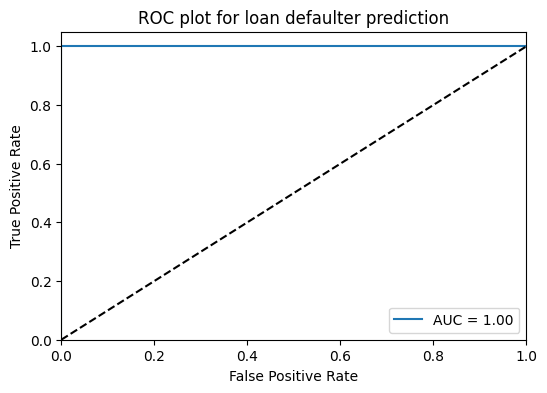

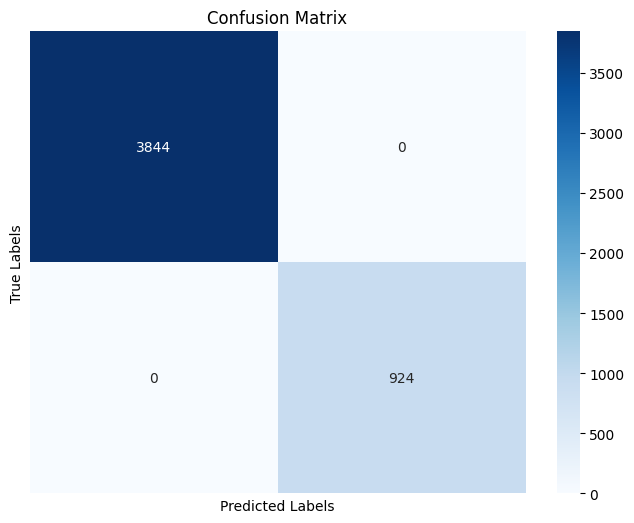

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3844
           1       1.00      1.00      1.00       924

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768

Testing Set:


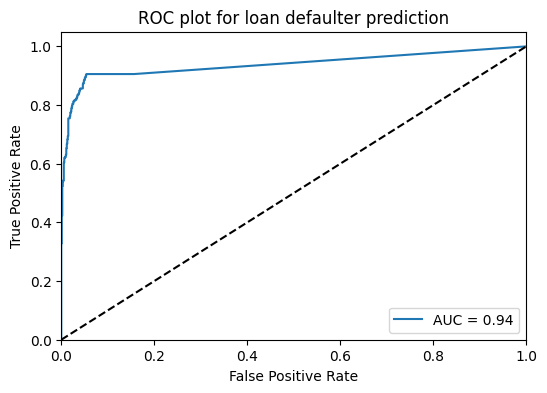

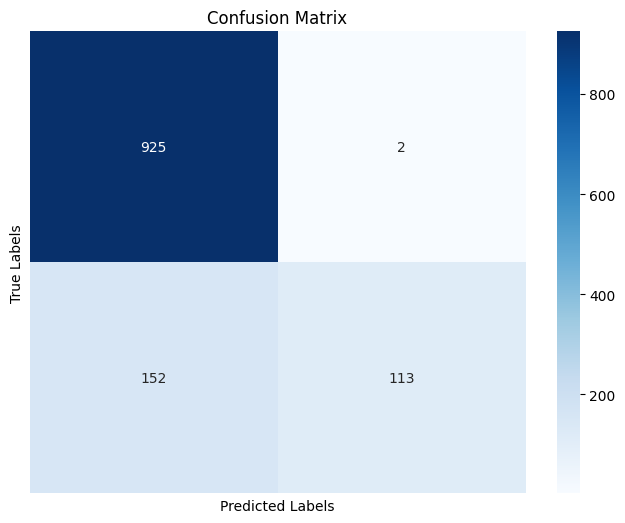

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       927
           1       0.98      0.43      0.59       265

    accuracy                           0.87      1192
   macro avg       0.92      0.71      0.76      1192
weighted avg       0.89      0.87      0.85      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.988509 using {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9962
Accuracy on Test Set: 0.9018
Recall on Training Set: 0.9827
Recall on Test Set: 0.5774
Training set


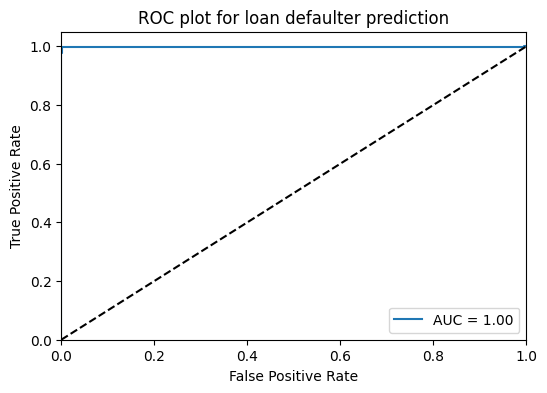

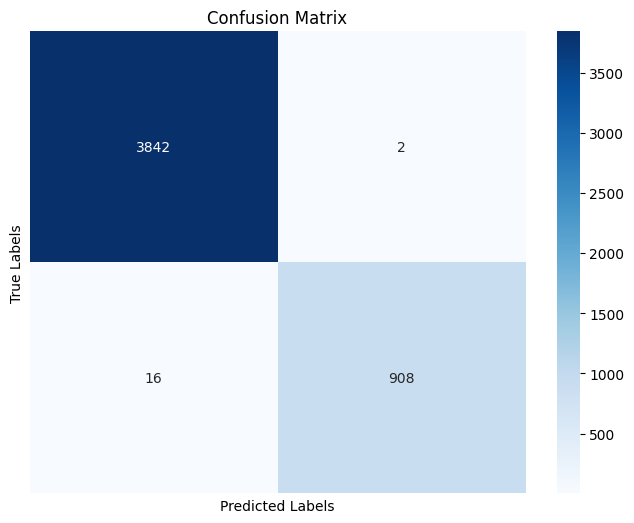

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3844
           1       1.00      0.98      0.99       924

    accuracy                           1.00      4768
   macro avg       1.00      0.99      0.99      4768
weighted avg       1.00      1.00      1.00      4768

Testing Set:


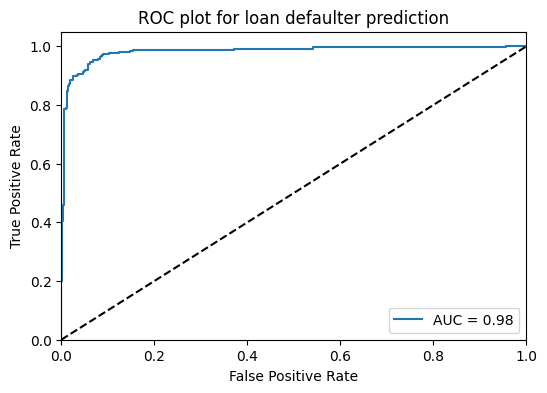

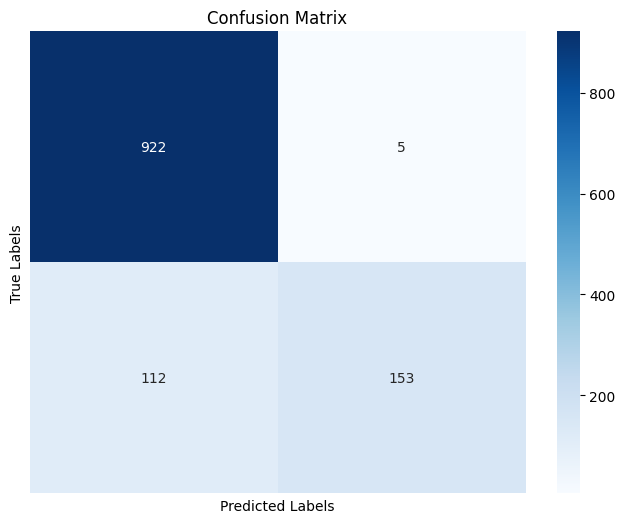

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       927
           1       0.97      0.58      0.72       265

    accuracy                           0.90      1192
   macro avg       0.93      0.79      0.83      1192
weighted avg       0.91      0.90      0.89      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.975765 using {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 1}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8431
Recall on Training Set: 1.0000
Recall on Test Set: 0.3019
Training set


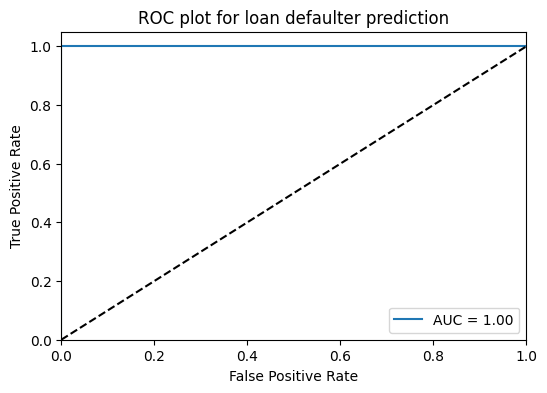

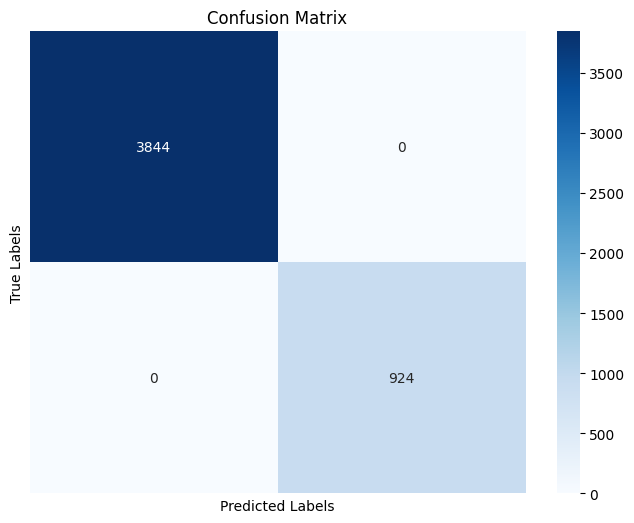

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3844
           1       1.00      1.00      1.00       924

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768

Testing Set:


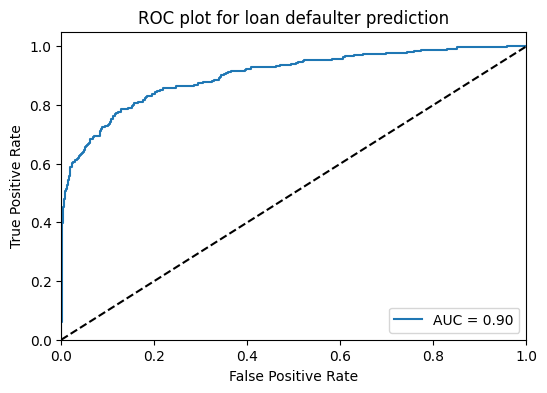

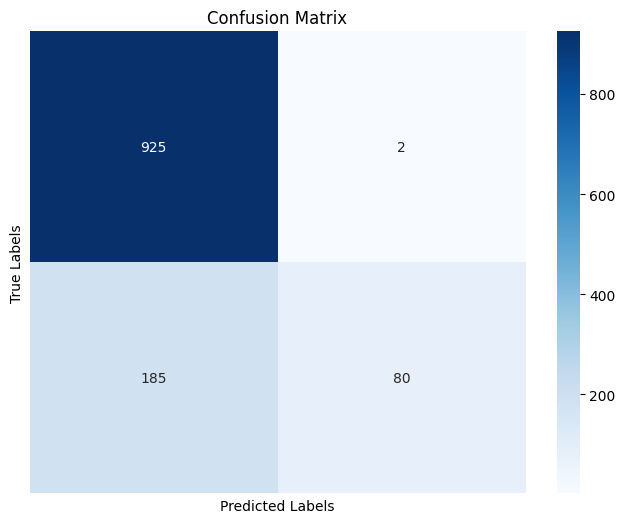

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       927
           1       0.98      0.30      0.46       265

    accuracy                           0.84      1192
   macro avg       0.90      0.65      0.68      1192
weighted avg       0.86      0.84      0.81      1192








In [60]:
build_and_train_model(models, param_grids, X_train_1, y_train_1, X_test_1, y_test_1, 1)

<h3>Credit Score for dataset

In [6]:
def credit_score(p):
    factor = 25 / np.log(2)
    offset = 600 - factor * np.log(50)
    val = (1-p) / p
    score = offset + factor * np.log(val)
    return round(score)